In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.preprocessing import StandardScaler

# Features

In [2]:
df = pd.read_csv('../data/clean.csv', index_col=0)

... all products exist all days

In [3]:
X = set(df['Product_Code'])
X_2012_01_03 = set(df[df.Date == '2012-01-03'].Product_Code)
len(X.intersection(X_2012_01_03)), len(X)

(25, 25)

In [4]:
X = df.groupby('Date').count()
X[X.Product_Code < 25]

,level_0,Product_Code,0,Volume
Date,,,,


In [5]:
time_idx = {d:i for i, d in enumerate(sorted(list(set(df.Date))))}

In [6]:
df['Volume'] = df['Volume'].apply(lambda x: float(x))
df["time_idx"] = df["Date"].apply(lambda date: time_idx[date])

min_time_idx = df['time_idx'].min()
df["time_idx"] -= min_time_idx
df = df.sort_values("time_idx")

In [7]:
df = df[['Date', 'Product_Code', 'Volume', 'time_idx']]
df

,Date,Product_Code,Volume,time_idx
0,2012-01-03,Product_0123,0.0,0
24,2012-01-03,Product_1669,60.0,0
23,2012-01-03,Product_1548,600.0,0
22,2012-01-03,Product_1539,550.0,0
21,2012-01-03,Product_1513,9300.0,0
...,...,...,...,...
36426,2015-12-30,Product_0200,50.0,1457
36425,2015-12-30,Product_0123,200.0,1457
36448,2015-12-30,Product_1548,50.0,1457
36436,2015-12-30,Product_1419,500.0,1457


# Fusion Transformer

In [37]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultivariateNormalDistributionLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


import lightning.pytorch as pl


In [53]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="Volume",
    group_ids=["Product_Code"],
    min_encoder_length=max_encoder_length // 4,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Product_Code"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Volume",
    ],
    target_normalizer=GroupNormalizer(
        groups=["Product_Code"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [54]:
pl.seed_everything(42)

Seed set to 42


42

In [55]:
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 223.7k


/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [30]:
import torch


best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

torch.save([best_tft._hparams, best_tft.state_dict()], 'tft.pth')


/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [56]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor(1914.4543)

In [57]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/dkohlsdorf/anaconda3/lib/python3.11/site-packages/pytorch_forecasting/models/base_model.py:1089: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


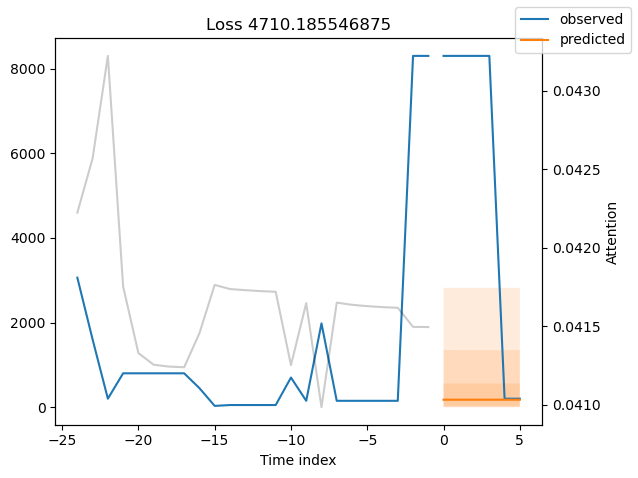

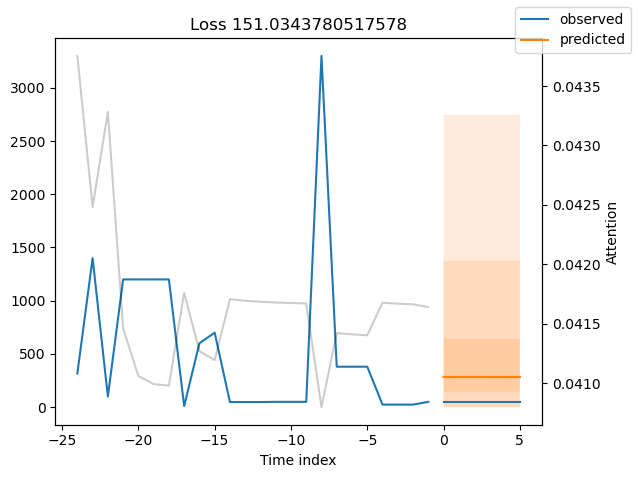

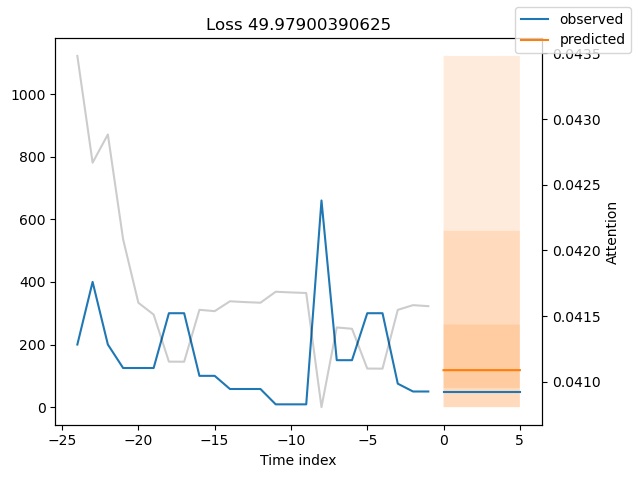

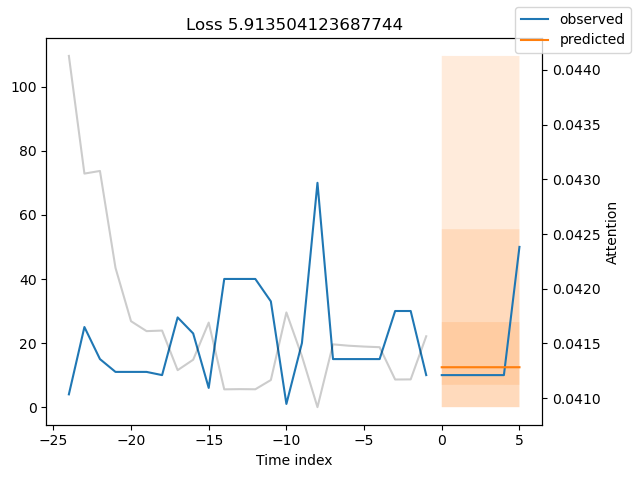

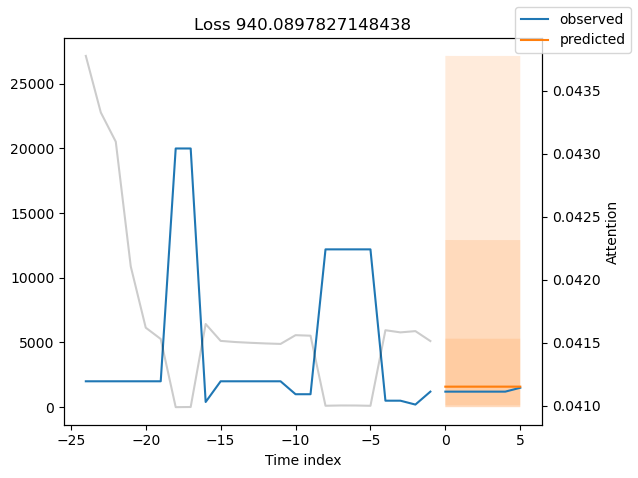

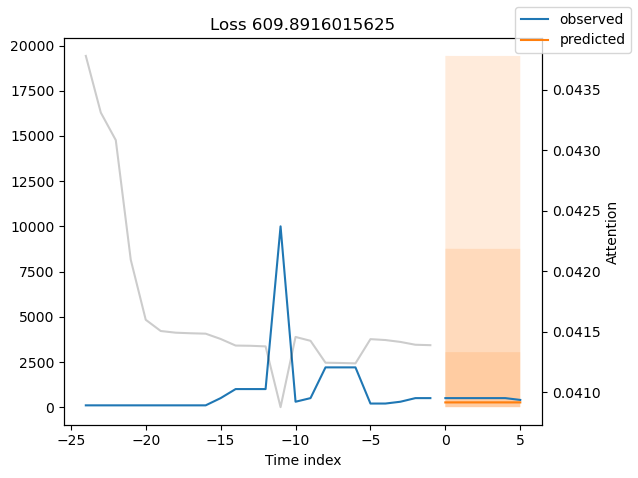

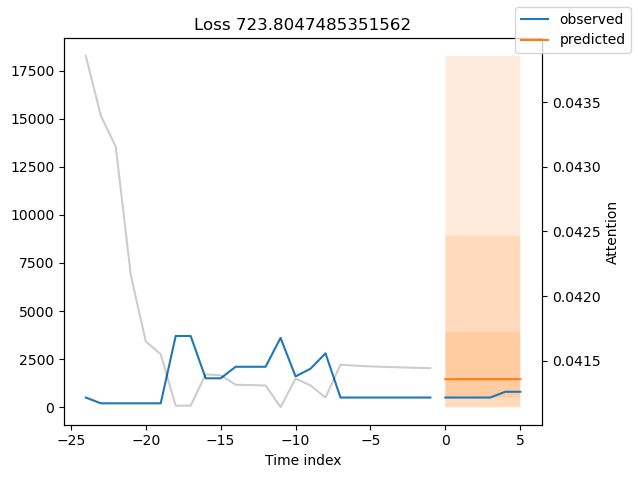

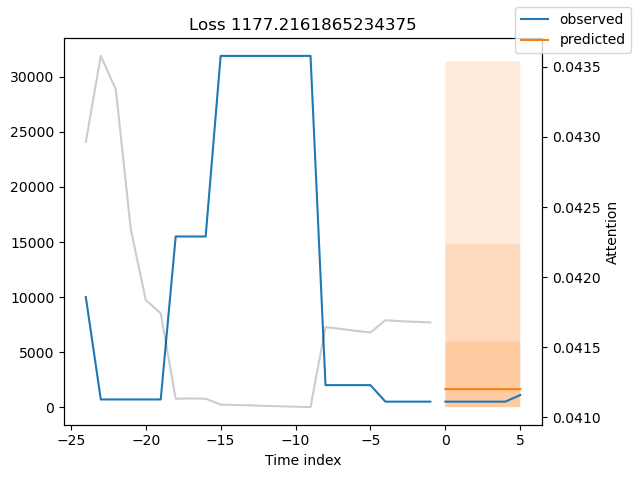

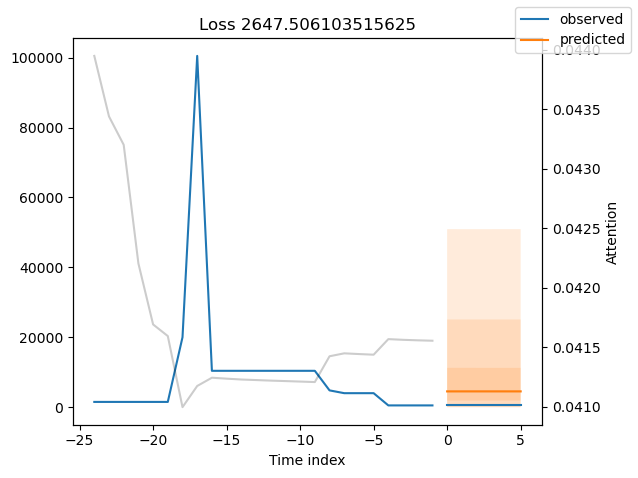

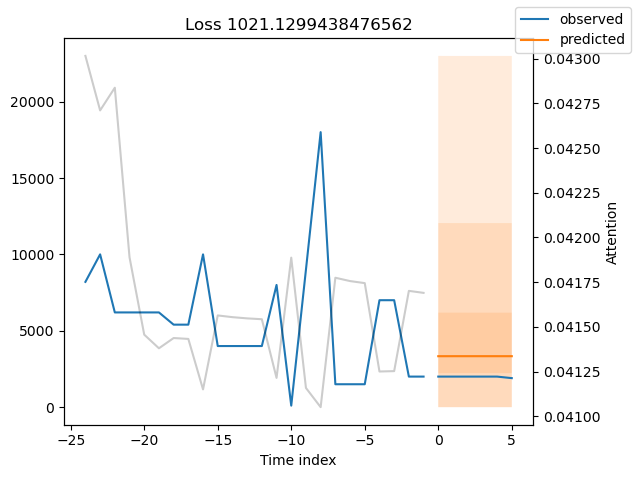

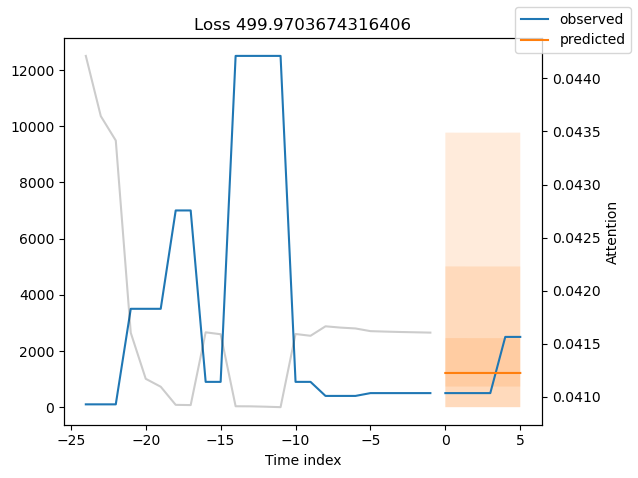

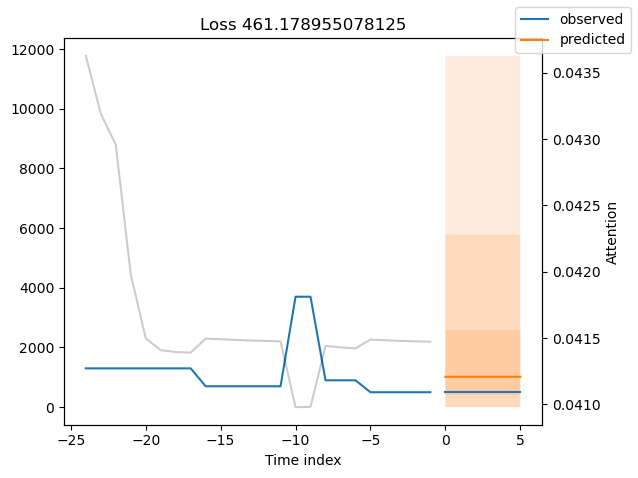

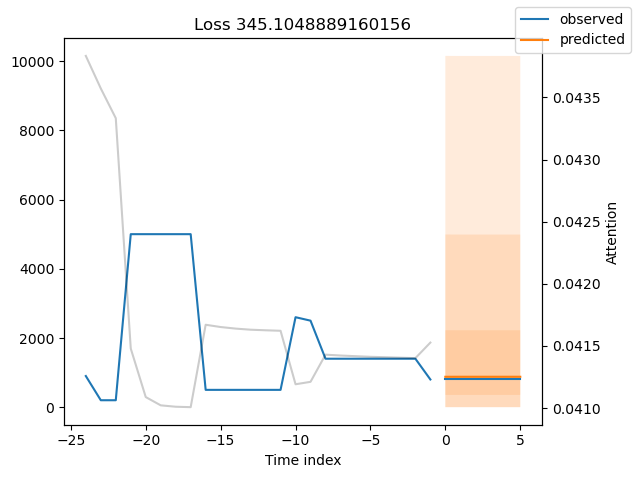

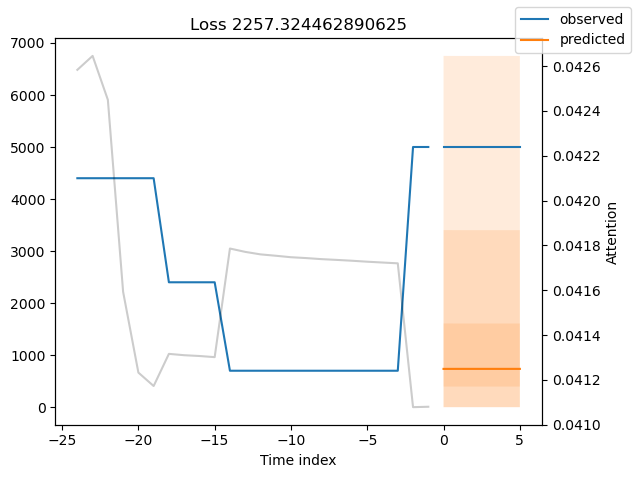

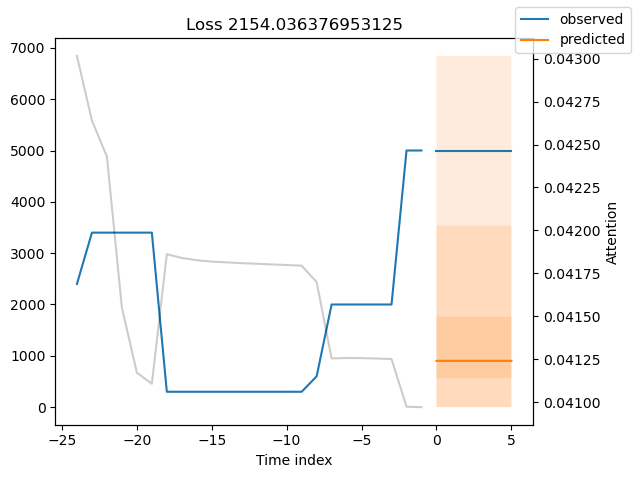

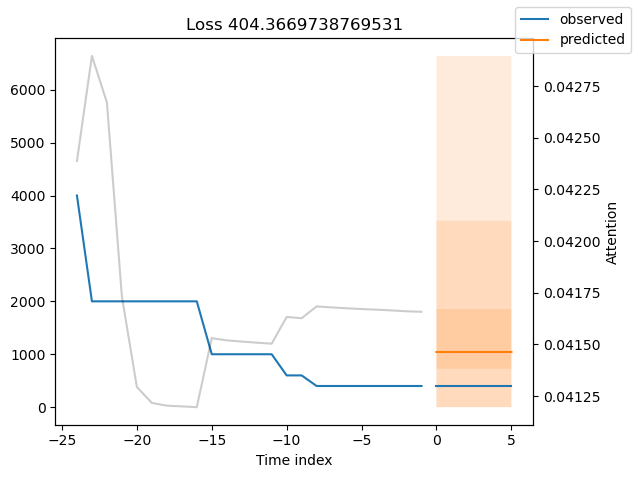

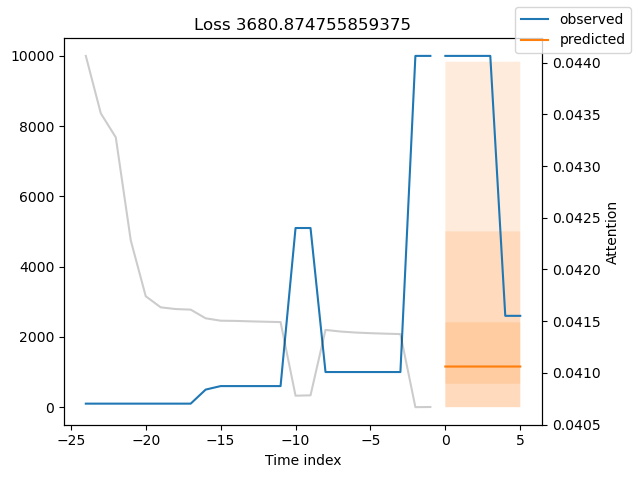

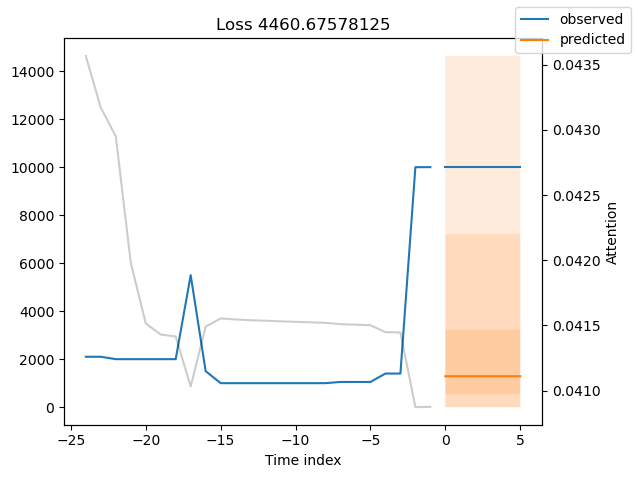

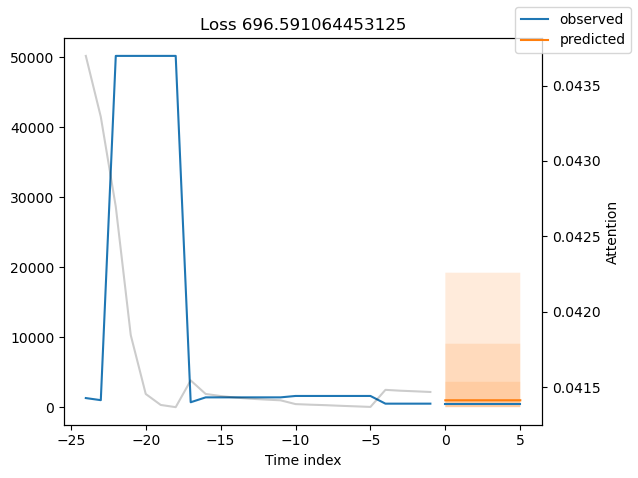

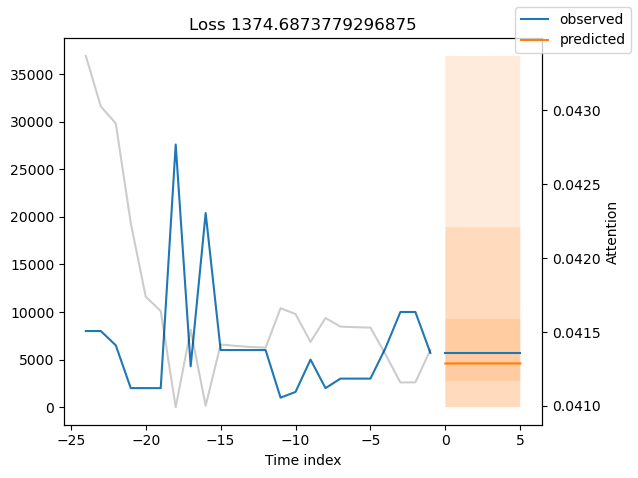

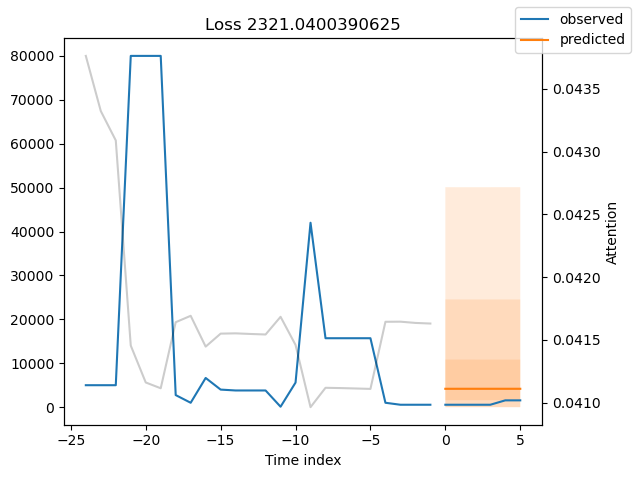

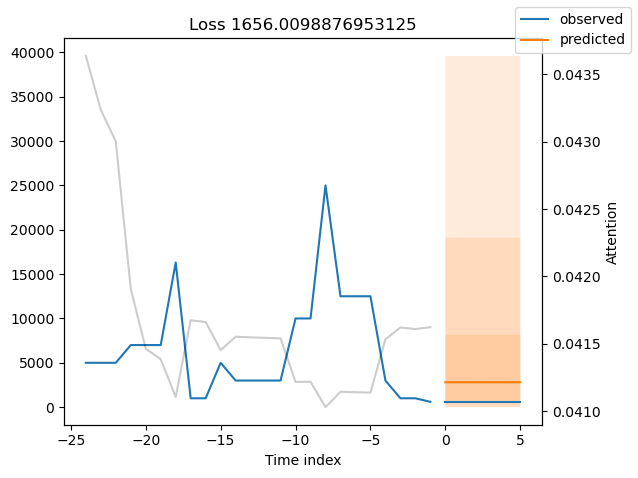

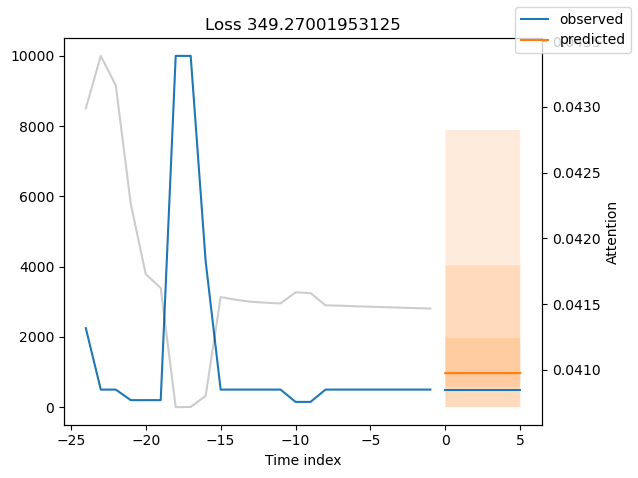

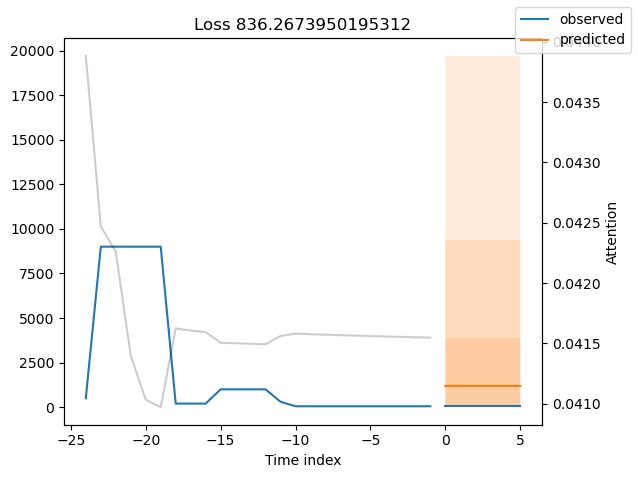

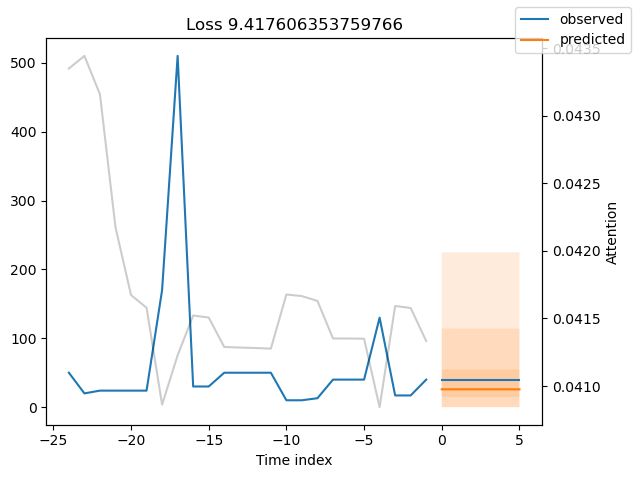

In [33]:
for idx in range(25):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)


In [58]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=25,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=25),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


AssertionError: Multivariate models require constant prediction lenghts